## Import Dependencies

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [38]:
df = pd.read_csv('/content/auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## Data Visualization


In [39]:
df.shape

(398, 9)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [41]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [42]:
df['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [43]:
print(df.shape)
df = df[df['horsepower']!='?']
print(df.shape)

(398, 9)
(392, 9)


In [44]:
df['horsepower'] = df['horsepower'].astype(int)
print(df.isnull().sum())
print(df.duplicated().sum())

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64
0


In [45]:
df.nunique()

,0
mpg,127
cylinders,5
displacement,81
horsepower,93
weight,346
acceleration,95
model year,13
origin,3
car name,301


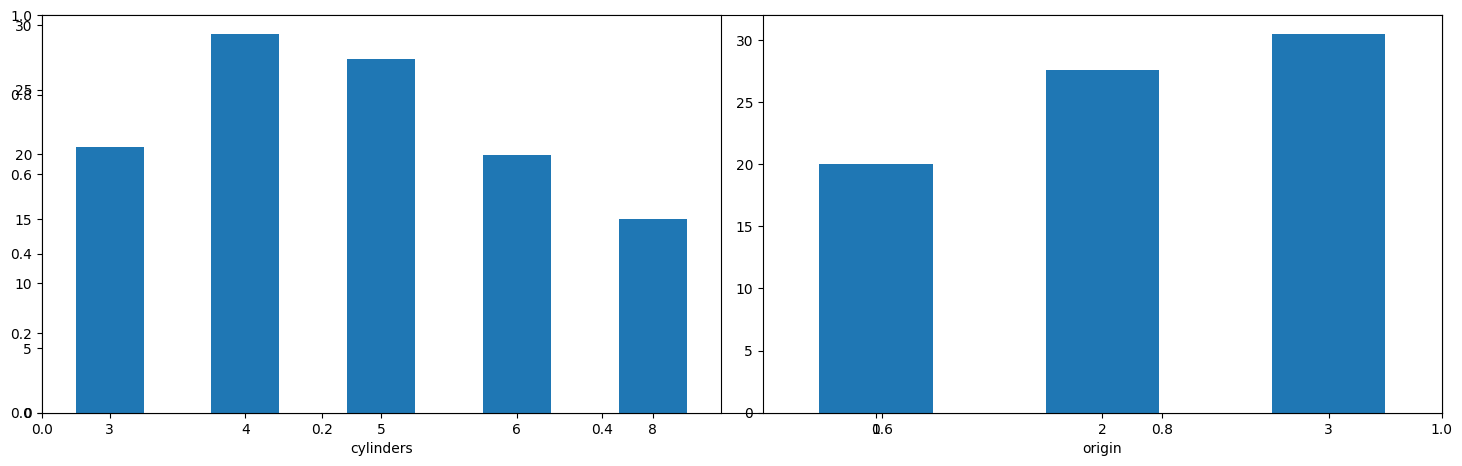

In [46]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['cylinders', 'origin']):
    plt.subplot(1, 2, i+1)
    x = df.groupby(col)['mpg'].mean()
    x.plot.bar()
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

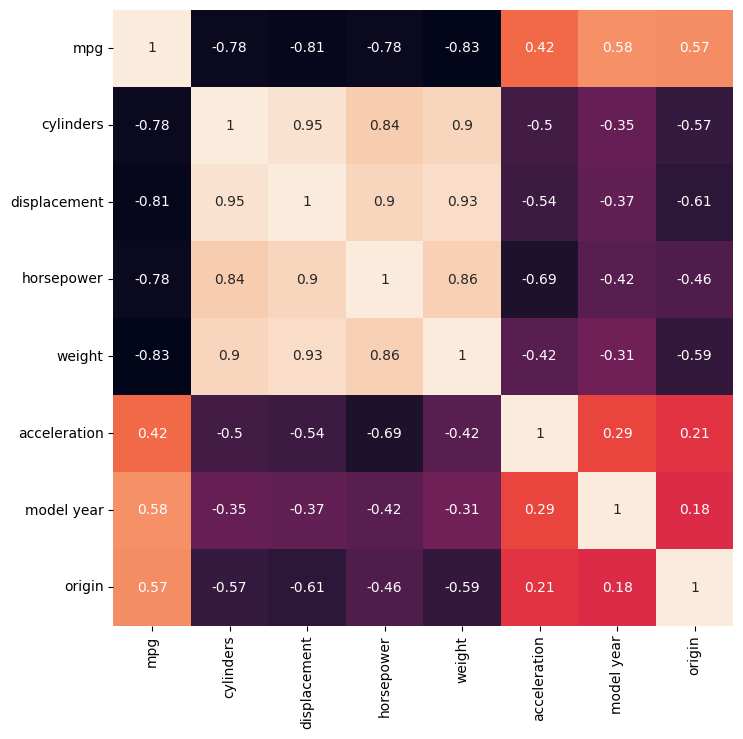

In [47]:
df_numeric = df.drop(columns=['car name'])

plt.figure(figsize=(8, 8))
sns.heatmap(df_numeric.corr(),
           annot=True,
           cbar=False)
plt.show()

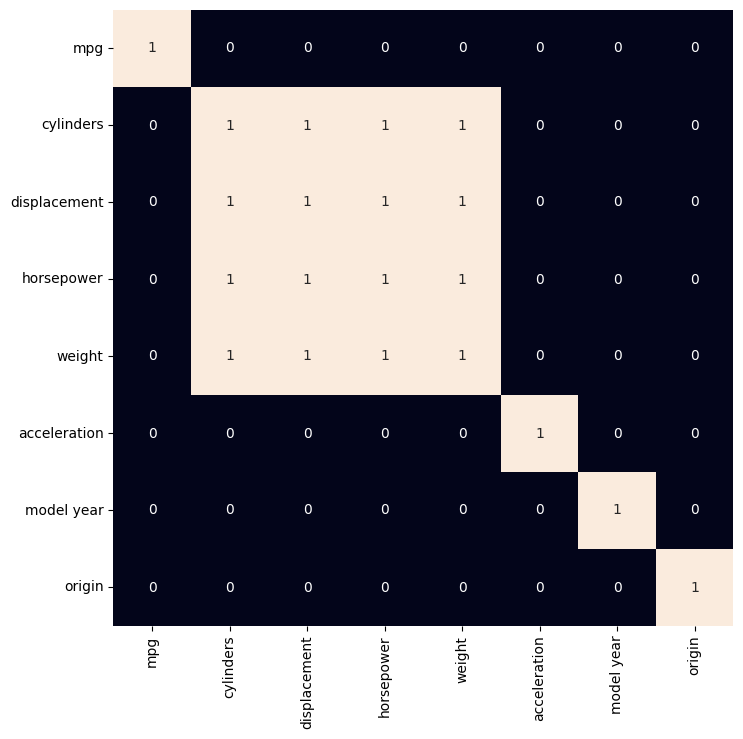

In [48]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_numeric.corr() > 0.7,
           annot=True,
           cbar=False)
plt.show()

In [49]:
df.drop(['displacement', 'horsepower', 'weight'],
        axis=1,
        inplace=True)

## Data Pipelining

In [50]:
from sklearn.model_selection import train_test_split
X = df.drop(['mpg', 'car name'], axis=1)
y = df['mpg'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((313, 4), (79, 4))

In [70]:
X_train.head()

,cylinders,acceleration,model year,origin
260,6,18.7,78,1
184,4,14.9,76,1
174,6,14.5,75,1
64,8,13.5,72,1
344,4,16.4,81,1


In [51]:
AUTO = tf.data.experimental.AUTOTUNE

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(32)
    .prefetch(AUTO)
)

## Model Building

In [52]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[4]),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='relu')
])

In [53]:
model.compile(
    loss='mae',
    optimizer='adam',
    metrics=['mape']
)

In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,377 (271.00 KB)

 Trainable params: 68,353 (267.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

## Model Training

In [55]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                      patience = 10,
                                      restore_best_weights=True)

lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='min',
    min_delta=1e-4,
    cooldown=0,
    min_lr=1e-6
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_checkpoint.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=0,
    mode='min'
)

history = model.fit(train_ds,
                   epochs=150,
                   validation_data=val_ds)

Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 21.8101 - mape: 90.6766 - val_loss: 22.8380 - val_mape: 100.0000
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.8569 - mape: 75.0063 - val_loss: 22.8380 - val_mape: 100.0000
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.8585 - mape: 71.0263 - val_loss: 22.8380 - val_mape: 100.0000
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.2332 - mape: 68.2749 - val_loss: 22.8380 - val_mape: 100.0000
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.6773 - mape: 65.6902 - val_loss: 22.8380 - val_mape: 100.0000
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 16.0685 - mape: 62.8115 - val_loss: 22.8380 - val_mape: 100.0000
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.5485 - mape: 60.4001 - val_loss: 22.8380 - val_mape: 100.0000
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.8861 - mape: 57.3958 - val_loss: 22.8380 - val_mape: 100.0000
Ep

In [56]:
history_df = pd.DataFrame(history.history)
history_df.head(150)

,loss,mape,val_loss,val_mape
0,21.160057,86.249161,22.837975,100.000000
1,18.812025,74.617714,22.837975,100.000000
2,17.774656,70.765961,22.837975,100.000000
3,17.194614,68.165344,22.837975,100.000000
4,16.617653,65.478806,22.837975,100.000000
...,...,...,...,...
145,2.771457,11.647489,2.523220,11.064364
146,2.673650,10.973593,3.043237,13.780445
147,2.785848,11.525573,3.224573,15.152812
148,2.833216,11.717656,2.552525,11.133226


## Loss Curves

<Axes: >

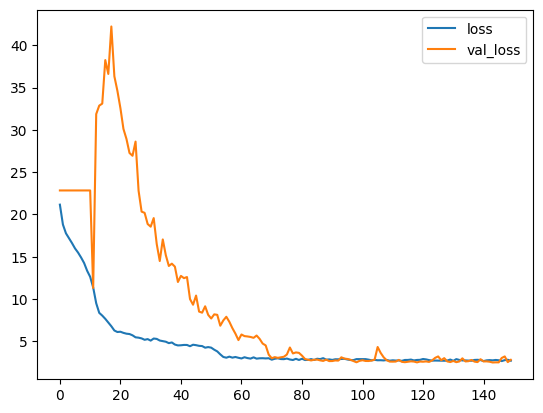

In [79]:
history_df.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

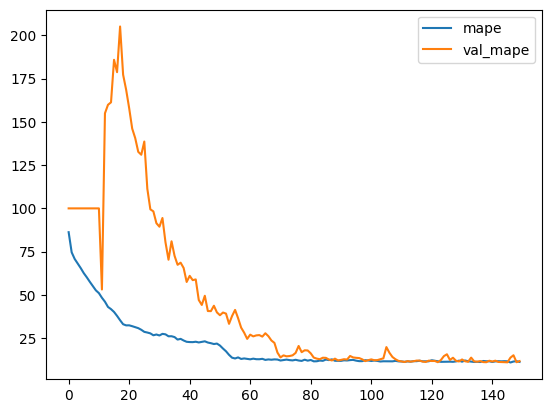

In [80]:
history_df.loc[:, ['mape', 'val_mape']].plot()

## Model Evaluation

In [77]:
model.evaluate(val_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8665 - mape: 11.6952 


[2.8236379623413086, 11.763494491577148]

## User-Defined Function to predict Fuel Eff

In [74]:
def predict_fuel_efficiency(cylinders, acceleration, model_year, origin):
    input_data = np.array([[cylinders, acceleration, model_year, origin]])
    prediction_prob = model.predict(input_data)
    predicted_class = np.argmax(prediction_prob, axis=1)[0]
    labels = ['Low', 'Medium', 'High']
    predicted_category = labels[predicted_class]
    return predicted_category

In [75]:
cylinders = 4
acceleration = 15.5
model_year = 80
origin = 1

predicted_category = predict_fuel_efficiency(cylinders, acceleration, model_year, origin)
print(f"The predicted fuel efficiency category is: {predicted_category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
The predicted fuel efficiency category is: Low
